In [20]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
from itertools import combinations
from functools import reduce

# from evaluate.lane import LaneEval
%matplotlib inline

In [21]:
DATA_PATH = "../test_set"
JSON_PATH = "json/output2.json"
OUTPUT_PATH = "../test_set/test_output"

<h3>Task 1: Dataset Visualization</h3>

In [22]:
test_json = [json.loads(line) for line in open('json/test_label.json').readlines()]

In [23]:
test_json[0].keys()

dict_keys(['lanes', 'h_samples', 'raw_file'])

In [24]:
def uno_instance(i):
    test_instance = test_json[i]
    gt_lanes = test_instance['lanes']
    y_samples = test_instance['h_samples']
    raw_file = os.path.join(DATA_PATH, test_instance['raw_file'])
    img = plt.imread(raw_file)
    gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
    img_vis = img.copy()

    for lane in gt_lanes_vis:
        for pt in lane:
            cv2.circle(img_vis, pt, radius=5, color=(0, 255, 0))

    plt.imshow(img_vis)
    plt.show()

    return

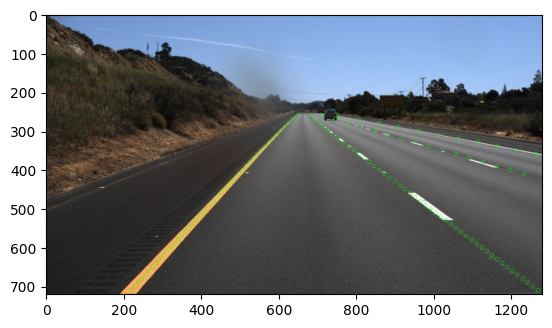

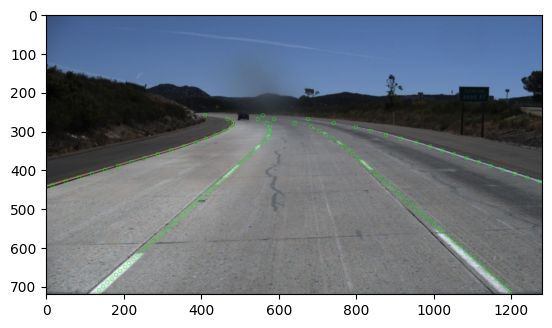

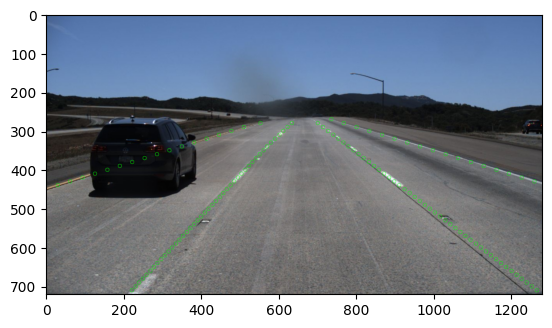

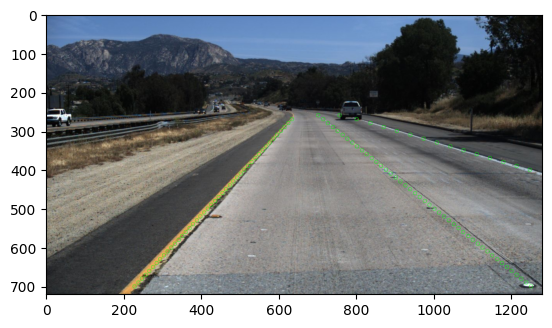

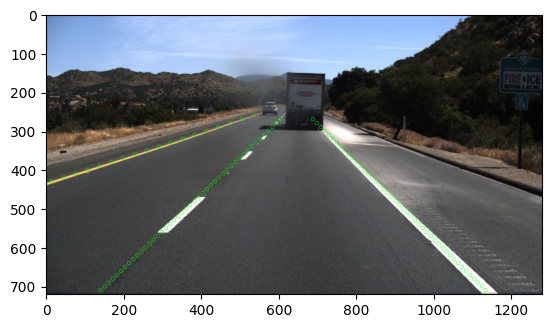

In [25]:
for i in range(5):
    uno_instance(i)

<h3>Task 2: Lane Detection</h3>

Their postprocess functions draws circles on each lines detected by one of their postprocess functions.
I store those points in a json file and also store the binary, instance seg masks if needed later. 
Then use the json file for Task 3.

Have modified the original notebook of laneNet detection to only run on 15 random images from the test set.

In [26]:
!python evaluate_lanenet_on_tusimple.py --image_dir ../test_set/clips --weights_path weights/tusimple_lanenet.ckpt --save_dir ../test_set/test_output --save_json json/output2.json

/bin/bash: /home/shayaan/anaconda3/envs/laneNet/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  0%|                                                    | 0/15 [00:00<?, ?it/s]2022-11-23 13:58:31.319 | INFO     | __main__:eval_lanenet:163 - Mean inference time every single image: 0.33408s
Images written
100%|███████████████████████████████████████████| 15/15 [00:06<00:00,  2.31it/s]
Json written


In [27]:
with open(JSON_PATH, 'r') as openfile:
 
    # Reading from json file
    json_object = json.load(openfile)
 
key = list(json_object.keys())[0]
value = json_object[key]
print("Image path ", key)
print("Num of lanes ", len(value))
for i in range(len(value)):
    print("Lane ", i, " has ", len(value[i]), " points")

Image path  clips/0530/1492627815283424034_0/8.jpg
Num of lanes  3
Lane  0  has  38  points
Lane  1  has  16  points
Lane  2  has  47  points


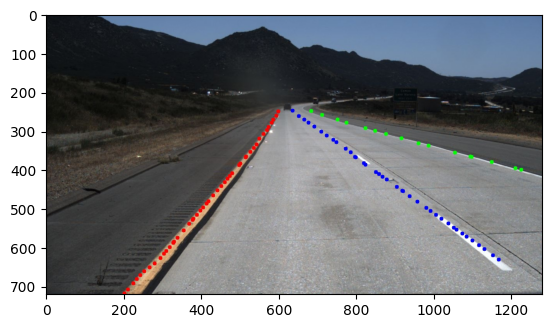

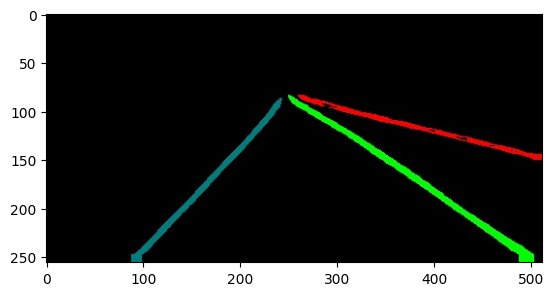

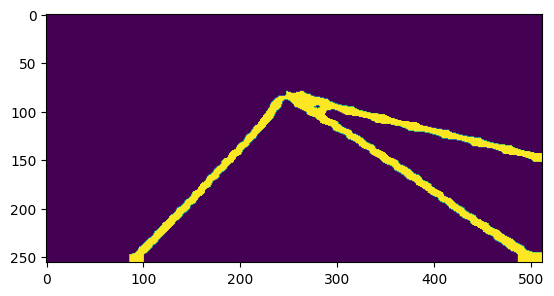

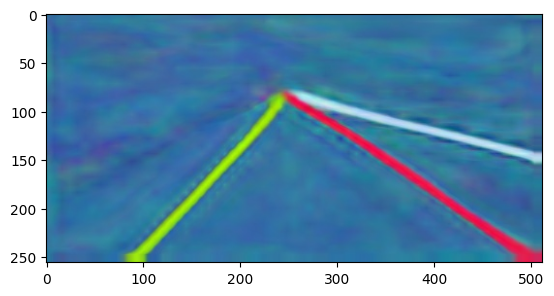

In [28]:
key_dir = "/".join(key.split('/')[1:-1])
outputPath = os.path.join(OUTPUT_PATH, key_dir)
os.listdir(outputPath)
for img in os.listdir(outputPath):
    img = plt.imread(os.path.join(outputPath, img))
    plt.imshow(img)
    plt.show()

<h3>Task 3: Vanishing Points</h3>

aik aur cheez krni idhr
kuch points outside of image aate for some reason. to wo dekhne ke agar outside of img widht and height h toh usko ignore krdo

In [29]:
def vanishing(points_file):
    f = open(points_file)
    pts = json.load(f)

    pts = {k:v for k, v in pts.items() if len(v) >= 3}

    keys = list(pts.keys())
    # print(keys)

    pts = [pts[i] for i in keys]
    # print(len(pts))
    # print([len(i) for i in pts])

    pts_lane = np.array([[random.sample(j, k=2) for j in i] for i in pts], dtype=object)
    # print(pts_lane)

    lines = np.array([[np.cross(np.append(j, [1]), np.append(k, [1])) for (j, k) in i] for i in pts_lane], dtype=object)
    # print(lines)
    # print("please add some space")
    pts_inf = np.array([[np.cross(x, y) for x, y in combinations(i, 2)] for i in lines], dtype=object)
    # print(pts_inf)

    vanishing_pt = np.array([reduce(lambda a, b: a+b, i)/len(i) for i in pts_inf], dtype=object)
    # print(vanishing_pt)

    vanishing_pt = {k:list(v) for k, v in zip(keys, vanishing_pt)}
    print(vanishing_pt)
    return vanishing_pt

In [30]:
vanishing(JSON_PATH)

{'clips/0530/1492627815283424034_0/8.jpg': [11470586.0, 4473855.0, 17948.0], 'clips/0601/1494453401646638002/12.jpg': [-5380393.0, 449401.1666666667, -11094.5], 'clips/0530/1492631498555184541_0/15.jpg': [3863293.3333333335, 1665378.6666666667, 6269.333333333333], 'clips/0601/1494453427635226083/16.jpg': [1149804.5, 180474.5, 515.5], 'clips/0530/1492631751402989647_0/5.jpg': [1981886.6666666667, 709604.0, 3180.3333333333335], 'clips/0531/1492626934515044019/17.jpg': [2170234.3333333335, 799788.6666666666, 3543.6666666666665], 'clips/0601/1495058597613077597/17.jpg': [22508609.833333332, 9303519.166666666, 36007.833333333336], 'clips/0530/1492638408037050500_0/8.jpg': [-64403108.666666664, -22823209.333333332, -99084.66666666667], 'clips/0531/1492629731089295543/20.jpg': [84064111.33333333, 29240715.333333332, 128366.0], 'clips/0601/1494453683523055480/16.jpg': [14699130.666666666, 5218797.333333333, 22298.666666666668], 'clips/0531/1492637493988554673/16.jpg': [3773808.0, 1197810.0, 54

{'clips/0530/1492627815283424034_0/8.jpg': [11470586.0, 4473855.0, 17948.0],
 'clips/0601/1494453401646638002/12.jpg': [-5380393.0,
  449401.1666666667,
  -11094.5],
 'clips/0530/1492631498555184541_0/15.jpg': [3863293.3333333335,
  1665378.6666666667,
  6269.333333333333],
 'clips/0601/1494453427635226083/16.jpg': [1149804.5, 180474.5, 515.5],
 'clips/0530/1492631751402989647_0/5.jpg': [1981886.6666666667,
  709604.0,
  3180.3333333333335],
 'clips/0531/1492626934515044019/17.jpg': [2170234.3333333335,
  799788.6666666666,
  3543.6666666666665],
 'clips/0601/1495058597613077597/17.jpg': [22508609.833333332,
  9303519.166666666,
  36007.833333333336],
 'clips/0530/1492638408037050500_0/8.jpg': [-64403108.666666664,
  -22823209.333333332,
  -99084.66666666667],
 'clips/0531/1492629731089295543/20.jpg': [84064111.33333333,
  29240715.333333332,
  128366.0],
 'clips/0601/1494453683523055480/16.jpg': [14699130.666666666,
  5218797.333333333,
  22298.666666666668],
 'clips/0531/149263749398

In [31]:
vanishing_pt = vanishing(JSON_PATH)
pt = list(vanishing_pt.keys())[0]
vanishing_pt[pt][-1]

{'clips/0530/1492627815283424034_0/8.jpg': [-3725486.0, -1397048.0, -5952.0], 'clips/0601/1494453401646638002/12.jpg': [29165598.0, 8217867.0, 40668.5], 'clips/0530/1492631498555184541_0/15.jpg': [1855390.6666666667, 853399.3333333334, 3087.3333333333335], 'clips/0601/1494453427635226083/16.jpg': [-33159374.333333332, -8353028.0, -42747.666666666664], 'clips/0530/1492631751402989647_0/5.jpg': [-14758680.0, -5414164.0, -22793.333333333332], 'clips/0531/1492626934515044019/17.jpg': [1929242.3333333333, 175964.66666666666, 4811.833333333333], 'clips/0601/1495058597613077597/17.jpg': [5513869.5, 1991056.3333333333, 6632.333333333333], 'clips/0530/1492638408037050500_0/8.jpg': [330590.6666666667, 63546.0, 546.0], 'clips/0531/1492629731089295543/20.jpg': [-7706104.333333333, -2577890.3333333335, -11719.0], 'clips/0601/1494453683523055480/16.jpg': [4892682.0, 1864518.0, 7383.0], 'clips/0531/1492637493988554673/16.jpg': [37685978.666666664, 12896736.666666666, 57396.666666666664], 'clips/0601/

-5952.0

{'clips/0530/1492627815283424034_0/8.jpg': [19528309.333333332, 7485864.0, 31307.333333333332], 'clips/0601/1494453401646638002/12.jpg': [-10061959.166666666, -3163134.0, -14065.166666666666], 'clips/0530/1492631498555184541_0/15.jpg': [1612315.0, 597920.0, 2490.0], 'clips/0601/1494453427635226083/16.jpg': [2371211.3333333335, 813107.1666666666, 3152.5], 'clips/0530/1492631751402989647_0/5.jpg': [-1556102.0, -557561.0, -2416.0], 'clips/0531/1492626934515044019/17.jpg': [-12190073.5, -4074280.3333333335, -19011.166666666668], 'clips/0601/1495058597613077597/17.jpg': [-30730638.5, -11902538.166666666, -48694.5], 'clips/0530/1492638408037050500_0/8.jpg': [6555072.666666667, 2616679.0, 10603.666666666666], 'clips/0531/1492629731089295543/20.jpg': [-9072447.333333334, -3176973.3333333335, -13709.666666666666], 'clips/0601/1494453683523055480/16.jpg': [-31851472.0, -11604540.666666666, -47843.333333333336], 'clips/0531/1492637493988554673/16.jpg': [36701746.0, 12798583.0, 55705.666666666664]

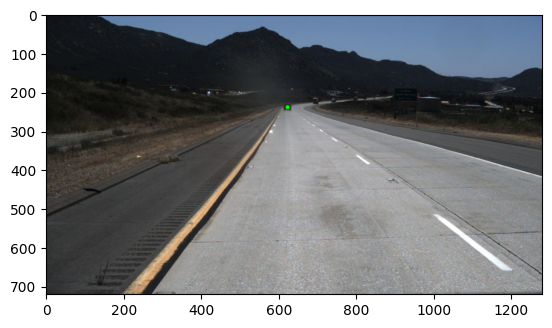

In [39]:
for i, j in vanishing(JSON_PATH).items():
        img = plt.imread(os.path.join(DATA_PATH, i))
        j = list(map(lambda x: x/j[-1], j))[:2]
        
        img = cv2.circle(img, (int(j[0]), int(j[1])), 5, (0, 255, 0), -1)
        plt.imshow(img)
        plt.show()
        break
    
    # key_dir = "/".join(key.split('/')[1:-1])
    # outputPath = os.path.join(OUTPUT_PATH, key_dir)
    # os.listdir(outputPath)
    # for img in os.listdir(outputPath):